# Kaggle San Francisco Crime Classification
## Berkeley MIDS W207 Final Project: Sam Goodgame, Sarah Cha, Kalvin Kao, Bryan Moore



### Environment and Data

In [21]:
# Additional Libraries
%matplotlib inline
import matplotlib.pyplot as plt

# Import relevant libraries:
import time
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# Import Meta-estimators
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Import Calibration tools
from sklearn.calibration import CalibratedClassifierCV

# Set random seed and format print output:
np.random.seed(0)
np.set_printoptions(precision=3)

### Local, individual load of updated data set (with weather data integrated) into training, development, and test subsets.


In [2]:
# Data path to your local copy of Kalvin's "x_data.csv", which was produced by the negated cell above
data_path = "./data/x_data_3.csv"
df = pd.read_csv(data_path, header=0)
x_data = df.drop('category', 1)
y = df.category.as_matrix()

# Impute missing values with mean values:
#x_complete = df.fillna(df.mean())
x_complete = x_data.fillna(x_data.mean())
X_raw = x_complete.as_matrix()

# Scale the data between 0 and 1:
X = MinMaxScaler().fit_transform(X_raw)

####
#X = np.around(X, decimals=2)
####

# Shuffle data to remove any underlying pattern that may exist.  Must re-run random seed step each time:
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, y = X[shuffle], y[shuffle]

# Due to difficulties with log loss and set(y_pred) needing to match set(labels), we will remove the extremely rare
# crimes from the data for quality issues.
X_minus_trea = X[np.where(y != 'TREA')]
y_minus_trea = y[np.where(y != 'TREA')]
X_final = X_minus_trea[np.where(y_minus_trea != 'PORNOGRAPHY/OBSCENE MAT')]
y_final = y_minus_trea[np.where(y_minus_trea != 'PORNOGRAPHY/OBSCENE MAT')]

# Separate training, dev, and test data:
test_data, test_labels = X_final[800000:], y_final[800000:]
dev_data, dev_labels = X_final[700000:800000], y_final[700000:800000]
train_data, train_labels = X_final[100000:700000], y_final[100000:700000]
calibrate_data, calibrate_labels = X_final[:100000], y_final[:100000]

# Create mini versions of the above sets
mini_train_data, mini_train_labels = X_final[:20000], y_final[:20000]
mini_calibrate_data, mini_calibrate_labels = X_final[19000:28000], y_final[19000:28000]
mini_dev_data, mini_dev_labels = X_final[49000:60000], y_final[49000:60000]

# Create list of the crime type labels.  This will act as the "labels" parameter for the log loss functions that follow
crime_labels = list(set(y_final))
crime_labels_mini_train = list(set(mini_train_labels))
crime_labels_mini_dev = list(set(mini_dev_labels))
crime_labels_mini_calibrate = list(set(mini_calibrate_labels))
print(len(crime_labels), len(crime_labels_mini_train), len(crime_labels_mini_dev),len(crime_labels_mini_calibrate))

#print(len(train_data),len(train_labels))
#print(len(dev_data),len(dev_labels))
print(len(mini_train_data),len(mini_train_labels))
print(len(mini_dev_data),len(mini_dev_labels))
#print(len(test_data),len(test_labels))
print(len(mini_calibrate_data),len(mini_calibrate_labels))
#print(len(calibrate_data),len(calibrate_labels))

37 37 37 37
20000 20000
11000 11000
9000 9000


## The Best RF Classifier

In [3]:
tuned_DT_calibrate_isotonic = RandomForestClassifier(min_impurity_split=1, 
                                       n_estimators=100, 
                                       bootstrap= True,
                                       max_features=15,
                                       criterion='entropy',
                                       min_samples_leaf=10,
                                       max_depth=None
                                      ).fit(train_data, train_labels)
ccv_isotonic = CalibratedClassifierCV(tuned_DT_calibrate_isotonic, method = 'isotonic', cv = 'prefit')
ccv_isotonic.fit(calibrate_data, calibrate_labels)
ccv_predictions = ccv_isotonic.predict(dev_data)
ccv_prediction_probabilities_isotonic = ccv_isotonic.predict_proba(dev_data)
working_log_loss_isotonic = log_loss(y_true = dev_labels, y_pred = ccv_prediction_probabilities_isotonic, labels = crime_labels)
print("Multi-class Log Loss with RF and calibration with isotonic is:", working_log_loss_isotonic)

Multi-class Log Loss with RF and calibration with isotonic is: 2.36876914674


## Distribution of Posterior Probabilities

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A458151898>]], dtype=object)

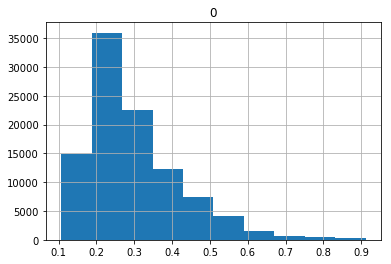

In [4]:
pd.DataFrame(np.amax(ccv_prediction_probabilities_isotonic, axis=1)).hist()

## Error Analysis: Calibration

In [16]:
#clf_probabilities, clf_predictions, labels
def error_analysis_calibration(buckets, clf_probabilities, clf_predictions, labels):
    """inputs:
    clf_probabilities = clf.predict_proba(dev_data)
    clf_predictions = clf.predict(dev_data)
    labels = dev_labels"""
    
    #buckets = [0.05, 0.15, 0.3, 0.5, 0.8]
    #buckets = [0.15, 0.25, 0.3, 1.0]
    correct = [0 for i in buckets]
    total = [0 for i in buckets]

    lLimit = 0
    uLimit = 0
    for i in range(len(buckets)):
        uLimit = buckets[i]
        for j in range(clf_probabilities.shape[0]):
            if (np.amax(clf_probabilities[j]) > lLimit) and (np.amax(clf_probabilities[j]) <= uLimit):
                if clf_predictions[j] == labels[j]:
                    correct[i] += 1
                total[i] += 1
        lLimit = uLimit

    #here we report the classifier accuracy for each posterior probability bucket
    accuracies = []
    for k in range(len(buckets)):
        print(1.0*correct[k]/total[k])
        accuracies.append(1.0*correct[k]/total[k])
        print('p(pred) <= %.13f    total = %3d    correct = %3d    accuracy = %.3f' \
              %(buckets[k], total[k], correct[k], 1.0*correct[k]/total[k]))
    f = plt.figure(figsize=(15,8))
    plt.plot(buckets,accuracies)
    plt.title("Calibration Analysis")
    plt.xlabel("Posterior Probability")
    plt.ylabel("Classifier Accuracy")
    
    return buckets, accuracies

0.17784624709566624
p(pred) <= 0.2000000000000    total = 19798    correct = 3521    accuracy = 0.178
0.21853365585119694
p(pred) <= 0.2500000000000    total = 23978    correct = 5240    accuracy = 0.219
0.2710680242634315
p(pred) <= 0.3000000000000    total = 18464    correct = 5005    accuracy = 0.271
0.3481006556112611
p(pred) <= 0.4000000000000    total = 20744    correct = 7221    accuracy = 0.348
0.46683380340541103
p(pred) <= 0.5000000000000    total = 9573    correct = 4469    accuracy = 0.467
0.6051274034703767
p(pred) <= 0.7000000000000    total = 6397    correct = 3871    accuracy = 0.605
0.804416403785489
p(pred) <= 0.9000000000000    total = 951    correct = 765    accuracy = 0.804
0.8947368421052632
p(pred) <= 1.0000000000000    total =  95    correct =  85    accuracy = 0.895


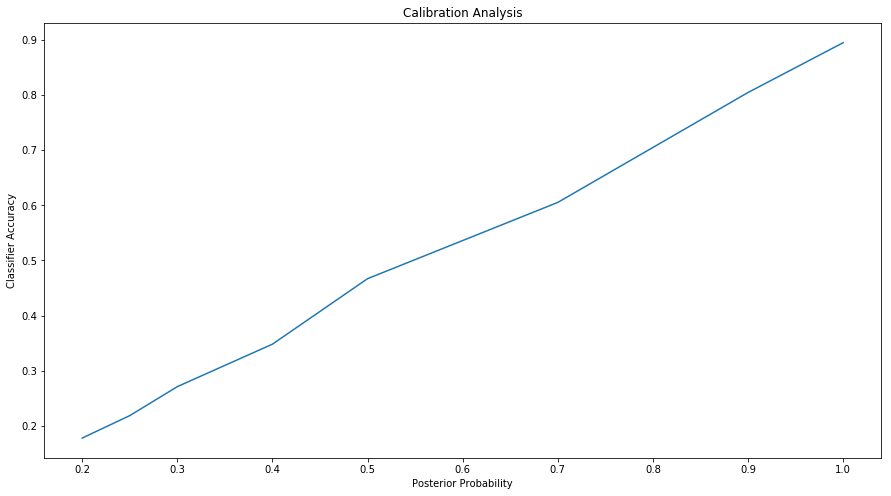

In [18]:
buckets = [0.2, 0.25, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0]
calibration_buckets, calibration_accuracies = \
error_analysis_calibration(buckets, \
                           clf_probabilities=ccv_prediction_probabilities_isotonic, \
                           clf_predictions=ccv_predictions, \
                           labels=dev_labels)

* The fact that the classifier accuracy is higher for predictions with a higher posterior probability shows that our model is strongly calibrated.  However, the distribution of these posterior probabilities shows that our classifier rarely has a 'confident' prediction.

## Error Analysis: Classification Report

In [19]:
def error_analysis_classification_report(clf_predictions, labels):
    """inputs:
    clf_predictions = clf.predict(dev_data)
    labels = dev_labels"""
    print('Classification Report:')
    report = classification_report(labels, clf_predictions)
    print(report)
    return report

In [22]:
classificationReport = error_analysis_classification_report(clf_predictions=ccv_predictions, \
                                                            labels=dev_labels)

Classification Report:
                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       155
                    ASSAULT       0.23      0.21      0.22      8885
                 BAD CHECKS       0.00      0.00      0.00        49
                    BRIBERY       0.00      0.00      0.00        31
                   BURGLARY       0.19      0.04      0.07      4145
         DISORDERLY CONDUCT       0.11      0.00      0.00       494
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       259
              DRUG/NARCOTIC       0.32      0.47      0.38      6228
                DRUNKENNESS       0.00      0.00      0.00       485
               EMBEZZLEMENT       0.00      0.00      0.00       137
                  EXTORTION       0.00      0.00      0.00        24
            FAMILY OFFENSES       0.00      0.00      0.00        59
     FORGERY/COUNTERFEITING       0.27      0.05      0.09      1279
          

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 * The classification report shows that the model still has issues of every sort with regards to accuracy-- both false positives and false negatives are an issue across many classes.
 * The relatively high recall scores for larceny/theft and prostitution are noticeable, showing that our model had fewer false negatives for these two classes.  However, their accuracies are still low.

## Error Analysis: Confusion Matrix

In [23]:
def error_analysis_confusion_matrix(label_names, clf_predictions, labels):
    """inputs:
    clf_predictions = clf.predict(dev_data)
    labels = dev_labels"""
    cm = pd.DataFrame(confusion_matrix(labels, clf_predictions, labels=label_names))
    cm.columns=label_names
    cm.index=label_names
    cm.to_csv(path_or_buf="./confusion_matrix.csv")
    #print(cm)
    return cm

In [24]:
error_analysis_confusion_matrix(label_names=crime_labels, clf_predictions=ccv_predictions, \
                                                            labels=dev_labels)

,LIQUOR LAWS,FORGERY/COUNTERFEITING,ARSON,BAD CHECKS,SEX OFFENSES NON FORCIBLE,DISORDERLY CONDUCT,BURGLARY,WEAPON LAWS,DRUNKENNESS,GAMBLING,...,WARRANTS,SUICIDE,ASSAULT,VANDALISM,FRAUD,DRIVING UNDER THE INFLUENCE,EMBEZZLEMENT,NON-CRIMINAL,SECONDARY CODES,RUNAWAY
LIQUOR LAWS,4,0,0,0,0,0,1,0,0,0,...,4,0,12,0,0,0,0,14,0,0
FORGERY/COUNTERFEITING,0,66,0,0,0,0,18,0,0,0,...,1,0,58,1,21,0,0,145,0,0
ARSON,0,0,0,0,0,0,4,0,0,0,...,0,0,34,2,0,0,0,6,0,0
BAD CHECKS,0,2,0,0,0,0,1,0,0,0,...,0,0,2,0,1,0,0,5,0,0
SEX OFFENSES NON FORCIBLE,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,2,0,0
DISORDERLY CONDUCT,0,0,0,0,0,1,3,0,0,1,...,3,0,36,0,0,0,0,41,0,0
BURGLARY,0,16,0,0,0,0,184,2,0,0,...,1,0,279,19,3,0,0,237,0,1
WEAPON LAWS,0,0,0,0,0,0,6,25,0,0,...,5,0,183,1,0,0,0,34,1,1
DRUNKENNESS,0,0,0,0,0,0,1,0,0,0,...,5,0,85,3,1,0,0,45,0,0
GAMBLING,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


#### Most Confused Classes:
 * Total times other crimes were incorrectly predicted to be:
   * 'Larceny/Theft': 28,737
   * 'Other Offenses': 14,841
   * 'Drug/Narcotic': 6,238
 * Total times the following classes were incorrectly predicted to be something else:
   * 'Other Offenses': 9,464
   * 'Non-Criminal': 8,740
   * 'Assault': 7,018

* The high recall score (lowest number of false positives) for 'Larceny/Theft' and high number of cases of other crimes being predicted to 'Larceny/Theft' indicates that our model may have a bias towards predicting this class.  This is not surprising given that it is also the most frequent class in our data, as shown in the distribution of training data crime classes.
* There is a high degree of both types of confusion surrounding the 'Other Offenses' category, but this can also be explained by the fact that it is the second most frequent class in our training data.  In fact, these classes with the most confusion are the top 5 most frequent classes in the training data, and this illustrates the great challenge that the skewed distribution of classes alone caused for our modeling.